imprements by https://www.kaggle.com/code/awsaf49/birdclef23-effnet-fsr-cutmixup-train

# Impoert library

In [1]:
import os
import random
from glob import glob
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

import torch

import librosa

In [2]:
from config import CFG
from pytorch_modeler import set_seed
import ogg2wav_preprocessing as prep

In [3]:
input_path='/kaggle/input/birdclef-2023-dataset/birdsong-recognition/train_audio/aldfly/XC135454.mp3'
out_path='./audio.wav'
#convert_to_wav(input_path,out_path)

In [4]:
set_seed(CFG.seed)

# Wandb

In [5]:
# # Import wandb library for logging and tracking experiments
# import wandb

# # Try to get the API key from Kaggle secrets
# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     # Login to wandb with the API key
#     wandb.login(key=api_key)
#     print('kaggle notebook mode')
# except:
#     key_path = '../../input/wandb_key.txt'
#     p = Path(key_path)
#     api_key = p.read_text()
#     wandb.login(key=api_key)
#     print('local mode')

In [6]:
df_23 = pd.read_csv(f'{CFG.BASE_PATH3}/train_metadata.csv')
df_23['filepath'] = CFG.BASE_PATH3 + '/train_audio/' + df_23.filename
df_23['target'] = df_23.primary_label.map(CFG.name2label)
df_23['birdclef'] = '23'
df_23['filename'] = df_23.filepath.map(lambda x: x.split('/')[-1])
df_23['xc_id'] = df_23.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
#assert tf.io.gfile.exists(df_23.filepath.iloc[0])

# Display rwos
print("# Samples in BirdCLEF 23: {:,}".format(len(df_23)))
df_23.head(2).style.set_caption("BirdCLEF - 23").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])

# Samples in BirdCLEF 23: 16,941


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,birdclef,xc_id
0,abethr1,[],['song'],4.390600,38.278800,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,4.000000,https://www.xeno-canto.org/128013,XC128013.ogg,/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg,0,23,XC128013
1,abethr1,[],['call'],-2.952400,38.292100,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.500000,https://www.xeno-canto.org/363501,XC363501.ogg,/kaggle/input/birdclef-2023/train_audio/abethr1/XC363501.ogg,0,23,XC363501


# Samples for Pre-Training: 80,394


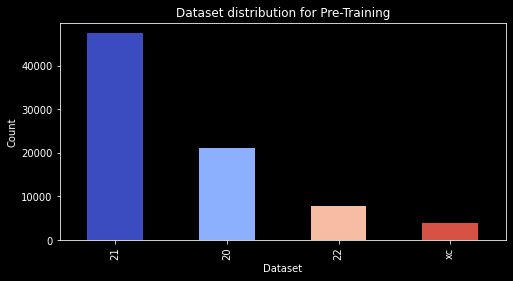

In [7]:
# BirdCLEF-2020
df_20 = pd.read_csv(f'{CFG.BASE_PATH0}/train.csv')
df_20['primary_label'] = df_20['ebird_code']
df_20['filepath'] = CFG.BASE_PATH0 + '/train_audio/' + df_20.primary_label + '/' + df_20.filename
df_20['scientific_name'] = df_20['sci_name']
df_20['common_name'] = df_20['species']
df_20['target'] = df_20.primary_label.map(CFG.name2label2)
df_20['birdclef'] = '20'
#assert tf.io.gfile.exists(df_20.filepath.iloc[0])

# Xeno-Canto Extend by @vopani
df_xam = pd.read_csv(f'{CFG.BASE_PATH4}/train_extended.csv')
df_xam['filepath'] = CFG.BASE_PATH4 + '/A-M/' + df_xam.ebird_code + '/' + df_xam.filename
df_xnz = pd.read_csv(f'{CFG.BASE_PATH5}/train_extended.csv')
df_xnz['filepath'] = CFG.BASE_PATH5 + '/N-Z/' + df_xnz.ebird_code + '/' + df_xnz.filename
df_xc = pd.concat([df_xam, df_xnz], axis=0, ignore_index=True)
df_xc['primary_label'] = df_xc['ebird_code']
df_xc['scientific_name'] = df_xc['sci_name']
df_xc['common_name'] = df_xc['species']
df_xc['target'] = df_xc.primary_label.map(CFG.name2label2)
df_xc['birdclef'] = 'xc'
#assert tf.io.gfile.exists(df_xc.filepath.iloc[0])

# BirdCLEF-2021
df_21 = pd.read_csv(f'{CFG.BASE_PATH1}/train_metadata.csv')
df_21['filepath'] = CFG.BASE_PATH1 + '/train_short_audio/' + df_21.primary_label + '/' + df_21.filename
df_21['target'] = df_21.primary_label.map(CFG.name2label2)
df_21['birdclef'] = '21'
corrupt_paths = [f'{CFG.BASE_PATH1}/train_short_audio/houwre/XC590621.ogg',
                 f'{CFG.BASE_PATH1}/train_short_audio/cogdov/XC579430.ogg']
df_21 = df_21[~df_21.filepath.isin(corrupt_paths)] # remove all zero audios
#assert tf.io.gfile.exists(df_21.filepath.iloc[0])

# BirdCLEF-2022
df_22 = pd.read_csv(f'{CFG.BASE_PATH2}/train_metadata.csv')
df_22['filepath'] = CFG.BASE_PATH2 + '/train_audio/' + df_22.filename
df_22['target'] = df_22.primary_label.map(CFG.name2label2)
df_22['birdclef'] = '22'
#assert tf.io.gfile.exists(df_22.filepath.iloc[0])

# Merge 2021 and 2022 for pretraining
df_pre = pd.concat([df_20, df_21, df_22, df_xc], axis=0, ignore_index=True)
df_pre['filename'] = df_pre.filepath.map(lambda x: x.split('/')[-1])
df_pre['xc_id'] = df_pre.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
nodup_idx = df_pre[['xc_id','primary_label','author']].drop_duplicates().index
df_pre = df_pre.loc[nodup_idx].reset_index(drop=True)

# # Remove duplicates
df_pre = df_pre[~df_pre.xc_id.isin(df_23.xc_id)].reset_index(drop=True)
corrupt_mp3s = json.load(open('/kaggle/input/birdclef-2023-dataset/corrupt_mp3_files.json','r'))
corrupt_mp3s = [path.replace('/kaggle/input','/kaggle/input/birdclef-2023-dataset') for path in corrupt_mp3s]
df_pre = df_pre[~df_pre.filepath.isin(corrupt_mp3s)]
df_pre = df_pre[['filename','filepath','primary_label','secondary_labels',
                 'rating','author','file_type','xc_id','scientific_name',
                'common_name','target','birdclef','bird_seen']]
# Display rows
print("# Samples for Pre-Training: {:,}".format(len(df_pre)))
df_pre.head(2).style.set_caption("Pre-Training Data").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '16px')
    ]
}])

# Show distribution
plt.figure(figsize=(8, 4))
df_pre.birdclef.value_counts().plot.bar(color=[cmap(0.0),cmap(0.25), cmap(0.65), cmap(0.9)])
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Dataset distribution for Pre-Training")
plt.show()

In [25]:
#import torchaudio

#audio=librosa.load('/kaggle/input/birdclef-2023-dataset/birdsong-recognition/train_audio/aldfly/XC135454.mp3', sr=32000, mono=False)[0]

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [26]:
#import soundfile as sf
#sf.write('./audio.wav', audio.T, 32000, format='wav', subtype='FLOAT')

In [9]:
df_pre['out_filepath'] = df_pre.filepath
df_pre['out_filepath'] = df_pre['out_filepath'].str.replace('ogg','wav')
df_pre['out_filepath'] = df_pre['out_filepath'].str.replace('mp3','wav')
audio_dir_names = ['train_audio','train_short_audio','A-M','N-Z']
for audio_dir_name in audio_dir_names:
    df_pre['out_filepath'] = df_pre['out_filepath'].str.replace(audio_dir_name, f'{audio_dir_name}_wav')
df_pre['out_dir'] = df_pre['out_filepath'].str.extract(r'(.*\/)[^\/]+$', expand=False)
for out_dir in df_pre.out_dir.unique().tolist():
   os.makedirs(out_dir, exist_ok=True)
#audio_dir_name = df_pre.out_filepath.str.split('/',expand=True)[5]
# audio_dir_name_unq = audio_dir_name.unique()
# for audio_dir_name in audio_dir_name_unq:
#     df_pre['filepath'] = df_pre['filepath'].str.replace(audio_dir_name, f'{audio_dir_name}_wav')

In [10]:
#df_pre['out_filepath'].str.split('/',expand=True)
#df_pre['out_filepath'] = df_pre['out_filepath'].str.extract(r'(.*\/)[^\/]+$', expand=False)

In [11]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df_pre = df_pre.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df_pre["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df_pre, df_pre['primary_label'])):
    df_pre.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [22]:
df_pre.iloc[64*930:]

,filename,filepath,primary_label,secondary_labels,rating,author,file_type,xc_id,scientific_name,common_name,target,birdclef,bird_seen,out_filepath,out_dir,fold
59520,XC489716.ogg,/kaggle/input/birdclef-2023-dataset/birdclef-2...,squcuc1,[],5.0,Diego Murta,NaN,XC489716,Piaya cayana,Squirrel Cuckoo,481,21,NaN,/kaggle/input/birdclef-2023-dataset/birdclef-2...,/kaggle/input/birdclef-2023-dataset/birdclef-2...,4
59521,XC490716.ogg,/kaggle/input/birdclef-2023-dataset/birdclef-2...,squcuc1,[],0.0,Fernando Igor de Godoy,NaN,XC490716,Piaya cayana,Squirrel Cuckoo,481,21,NaN,/kaggle/input/birdclef-2023-dataset/birdclef-2...,/kaggle/input/birdclef-2023-dataset/birdclef-2...,2
59522,XC490717.ogg,/kaggle/input/birdclef-2023-dataset/birdclef-2...,squcuc1,[],0.0,Fernando Igor de Godoy,NaN,XC490717,Piaya cayana,Squirrel Cuckoo,481,21,NaN,/kaggle/input/birdclef-2023-dataset/birdclef-2...,/kaggle/input/birdclef-2023-dataset/birdclef-2...,0
59523,XC496463.ogg,/kaggle/input/birdclef-2023-dataset/birdclef-2...,squcuc1,[],0.0,Fernando Igor de Godoy,NaN,XC496463,Piaya cayana,Squirrel Cuckoo,481,21,NaN,/kaggle/input/birdclef-2023-dataset/birdclef-2...,/kaggle/input/birdclef-2023-dataset/birdclef-2...,1
59524,XC497499.ogg,/kaggle/input/birdclef-2023-dataset/birdclef-2...,squcuc1,[],5.0,Richard E. Webster,NaN,XC497499,Piaya cayana,Squirrel Cuckoo,481,21,NaN,/kaggle/input/birdclef-2023-dataset/birdclef-2...,/kaggle/input/birdclef-2023-dataset/birdclef-2...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80389,XC513819.mp3,/kaggle/input/birdclef-2023-dataset/xeno-canto...,mouchi,[],3.0,Fernando del Valle,mp3,XC513819,Poecile gambeli,Mountain Chickadee,324,xc,no,/kaggle/input/birdclef-2023-dataset/xeno-canto...,/kaggle/input/birdclef-2023-dataset/xeno-canto...,3
80390,XC256763.mp3,/kaggle/input/birdclef-2023-dataset/xeno-canto...,mouchi,[],3.0,Elisa Yang,mp3,XC256763,Poecile gambeli,Mountain Chickadee,324,xc,yes,/kaggle/input/birdclef-2023-dataset/xeno-canto...,/kaggle/input/birdclef-2023-dataset/xeno-canto...,1
80391,XC240242.mp3,/kaggle/input/birdclef-2023-dataset/xeno-canto...,mouchi,[],2.0,Carrie Branch,mp3,XC240242,Poecile gambeli,Mountain Chickadee,324,xc,yes,/kaggle/input/birdclef-2023-dataset/xeno-canto...,/kaggle/input/birdclef-2023-dataset/xeno-canto...,4
80392,XC240241.mp3,/kaggle/input/birdclef-2023-dataset/xeno-canto...,mouchi,[],2.0,Carrie Branch,mp3,XC240241,Poecile gambeli,Mountain Chickadee,324,xc,yes,/kaggle/input/birdclef-2023-dataset/xeno-canto...,/kaggle/input/birdclef-2023-dataset/xeno-canto...,4


In [12]:
train_dataset = prep.BirdDataset(df_pre, is_train=True)

In [13]:
def inference_collate(batch):
    features, sample_info = list(zip(*batch))
    features = torch.cat(features, dim=0)
    # info
    batched_info = {}
    
    # 最初のサンプルからすべてのデータ項目のキーを取得
    keys = [k for d in sample_info[0] for k in d.keys()]

    # キーに基づいてデータをバッチ化
    for key in keys:
        # 各キーに対応する値のリストを作成
        values = [d[key] for sample in sample_info for d in sample if key in d]

        # 値がテンソルであることを確認し、スタックしてバッチ化
        if isinstance(values[0], torch.Tensor):
            batched_info[key] = torch.stack(values, dim=0)
        # テンソルでない場合は、リストとして保存
        else:
            batched_info[key] = values
    return features, batched_info

def collate_fn(batch):
    features, sample_info = list(zip(*batch))
    
    return features, sample_info

ogg2wav_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers = os.cpu_count(),
    collate_fn=collate_fn
    )

In [21]:
train_dataset[64*930:]

error_file:  59520    /kaggle/input/birdclef-2023-dataset/birdclef-2...
59521    /kaggle/input/birdclef-2023-dataset/birdclef-2...
59522    /kaggle/input/birdclef-2023-dataset/birdclef-2...
59523    /kaggle/input/birdclef-2023-dataset/birdclef-2...
59524    /kaggle/input/birdclef-2023-dataset/birdclef-2...
                               ...                        
80389    /kaggle/input/birdclef-2023-dataset/xeno-canto...
80390    /kaggle/input/birdclef-2023-dataset/xeno-canto...
80391    /kaggle/input/birdclef-2023-dataset/xeno-canto...
80392    /kaggle/input/birdclef-2023-dataset/xeno-canto...
80393    /kaggle/input/birdclef-2023-dataset/xeno-canto...
Name: filepath, Length: 20874, dtype: object


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 {'filename': {59520: 'XC489716.ogg',
   59521: 'XC490716.ogg',
   59522: 'XC490717.ogg',
   59523: 'XC496463.ogg',
   59524: 'XC497499.ogg',
   59525: 'XC497985.ogg',
   59526: 'XC500052.ogg',
   59527: 'XC502530.ogg',
   59528: 'XC505877.ogg',
   59529: 'XC505878.ogg',
   59530: 'XC50839.ogg',
   59531: 'XC50843.ogg',
   59532: 'XC50844.ogg',
   59533: 'XC50845.ogg',
   59534: 'XC511864.ogg',
   59535: 'XC512517.ogg',
   59536: 'XC516269.ogg',
   59537: 'XC518098.ogg',
   59538: 'XC524036.ogg',
   59539: 'XC529548.ogg',
   59540: 'XC531570.og

In [14]:
from tqdm import tqdm

for idx, (features, sample_info) in enumerate(tqdm(ogg2wav_loader[930:])):
    continue

TypeError: 'DataLoader' object is not subscriptable